<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch4-DP/Gamblers_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

# Gambler's Problem

A Gambler makes bets on the outcomes of a sequency of coin flips. If the coin comes up heads, he wins as much money has he as staked on that flip; if its tails he loses his stake. Gambler wins by reaching his goal of $100 or loses by running out of money.

**State:** Amount of money gambler currently has. i.e. $s \in \{1,2,...,99\}$

**Action:** Amount gambler stakes in each round. i.e. $a \in \{0,1,2,...,min(s,100-s)\}$

**Problem type:** Undiscounted ($\gamma = 1$) and episodic (reward = 0 for all transitions except when the game terminates) finite MDP. State & action are integers

## Approach

1.   State is the earnings $s \in \{1,2,...,99\}$
2.   Action is the amount to be staked i.e. $a \in \{0,1,2,...,min(s,100-s)\}$. The min function indicates that if the gambler has \\$60 in his pot, he needs to stake a minimum of \\$40 (=\\$100-\\$60) to be able to win the game. While the minimum function is not necessary, it does not affect the solution in any way because of the assumption in (3) below.
3.   Probability of landing heads, $p_h = 0.4$ is a constant and is independent of the action/states.
4.   The next state $s_{k+1}$ can take 2 values $s_{k+1} = \Bigg\{\begin{matrix}s_k + a_k & \text{with } probability = P_h \\ s_k - a_k & \text{with } probability = 1-P_h\end{matrix}$
5.   Reward at step $k$ is give by: $r_k = \Bigg\{\begin{matrix} 1 & \text{if } s_k >= 100 \\ 0 & otherwise \end{matrix}$
6.   From (4) above, the transition probability is defined as follows:
      $$ \begin{align*}P(s_{k+1} = s_k + a_k|a=a_k) &= P_h \\ P(s_{k+1} = s_k - a_k|a=a_k) &= 1-P_h \end{align*}$$
7.    Initial Policy - Define initial policy as an equi-probable density for all possible actions





## Parameters

In [0]:
p_h = 0.4
maxEarnings = 100
minEarnings = 0
gamma = 1.

## Code

In [0]:
p_coin = [p_h,1-p_h]
def get_actions(s):
  return np.array(list(range(1,min(s+1,maxEarnings+1-s))))

def getInitPolicy():
  pi = [[]]
  for i in range(minEarnings+1,maxEarnings):
    a = get_actions(i)
    pi.append(np.ones((len(a),))/float(len(a)))
  return pi

def evaluate_policy(v_s,pi):
  vs = np.copy(v_s)
  for i in range(maxEarnings-1,minEarnings,-1):
  # for i in range(minEarnings+1,maxEarnings):
    total_val = 0
    act = get_actions(i)
    for ii,a in enumerate(act):
      val = 0
      for k in range(2):
        next = max(0,min(maxEarnings,i+(-1)**k*(a)))
        if next == maxEarnings:
          val = val + p_coin[k]*1
        elif next > 0:
          val = val + p_coin[k]*(0 + gamma*vs[next])
      total_val = total_val + pi[i][ii]*val
    vs[i] = total_val    
  return vs

def improve_policy(v_s):
  pi = []
  for i in range(minEarnings+1,maxEarnings):
    act = get_actions(i)
    act_val = np.zeros((len(act),))
    act_prob = np.zeros((len(act),))
    for ii,a in enumerate(act):
      val = 0
      for k in range(2):
        next = max(0,min(maxEarnings,i+(-1)**k*(a)))
        if next == maxEarnings:
          val = val + p_coin[k]*1
        elif next > 0:
          val = val + p_coin[k]*(0 + gamma*vs[next])
      act_val[ii] = val
    max_val = np.max(act_val)
    max_a = np.where(act_val == max_val)[0]
    if len(max_a) > 1:
      pass
    act_prob[max_a[0]] = 1
    pi.append(act_prob)
  return pi

def getBestAction(pi):
  action = []
  # print("Size of action:",len(action))
  for i,p in enumerate(pi):
    # print('Best Action:',i,np.where(p == np.max(p))[0][0])
    action.append(1+np.where(p == np.max(p))[0][0])
  return action

In [22]:
v_s = np.zeros((maxEarnings,))
pi_init = getInitPolicy()

s = 1
print(pi_init[s])
print(get_actions(s))
# print(list(range(maxEarnings-1,0,-1)))

[1.]
[1]


0 4.923267539405236


IndexError: ignored

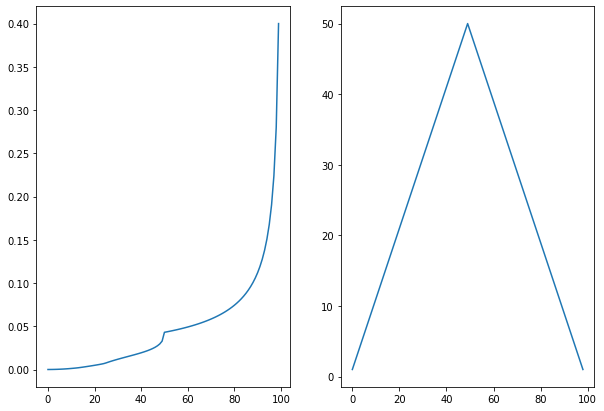

In [24]:
iter = 0
iter_max = 2

fig,ax = plt.subplots(1,2,figsize=(10,7))
vs_prev = np.copy(v_s)
pi_prev = np.copy(pi_init)
exitFlag = False
while iter < iter_max and not exitFlag:
  vs = evaluate_policy(vs_prev,pi_prev)
  pi = improve_policy(vs)
  if np.max(np.abs(vs-vs_prev)) < 0.001 and np.max(np.abs(pi-pi_prev)) < 1E-2:
    exitFlag = True
  vs_prev = np.copy(vs)
  pi_prev = np.copy(pi)
  print(iter,np.sum(vs))
  # print(np.round(vs,3))
  # print("######")
  
  iter = iter + 1
  ax[0].plot(range(len(vs)),vs)
  ax[1].plot(range(len(pi)),getBestAction(pi))



In [20]:
# print(getBestAction(pi))
print(len(pi))
action = np.zeros((len(pi),))
pi_mat = getBestAction(pi_prev)

99
Best Action: 0 0
Best Action: 1 1
Best Action: 2 2
Best Action: 3 3
Best Action: 4 4
Best Action: 5 5
Best Action: 6 6
Best Action: 7 7
Best Action: 8 8
Best Action: 9 9
Best Action: 10 10
Best Action: 11 11
Best Action: 12 12
Best Action: 13 13
Best Action: 14 14
Best Action: 15 15
Best Action: 16 16
Best Action: 17 17
Best Action: 18 18
Best Action: 19 19
Best Action: 20 20
Best Action: 21 21
Best Action: 22 22
Best Action: 23 23
Best Action: 24 24
Best Action: 25 25
Best Action: 26 26
Best Action: 27 27
Best Action: 28 28
Best Action: 29 29
Best Action: 30 30
Best Action: 31 31
Best Action: 32 32
Best Action: 33 33
Best Action: 34 34
Best Action: 35 35
Best Action: 36 36
Best Action: 37 37
Best Action: 38 38
Best Action: 39 39
Best Action: 40 40
Best Action: 41 41
Best Action: 42 42
Best Action: 43 43
Best Action: 44 44
Best Action: 45 45
Best Action: 46 46
Best Action: 47 47
Best Action: 48 48
Best Action: 49 49
Best Action: 50 48
Best Action: 51 47
Best Action: 52 46
Best Actio